# USAD
## Importing packages

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, f1_score, roc_curve,roc_auc_score, precision_score, recall_score

In [1]:
!ls data

 SWaT_Dataset_Attack_v0.csv    SWaT_Dataset_Normal_v1.xlsx
 SWaT_Dataset_Attack_v0.xlsx   WADI_14days_new.csv
 SWaT_Dataset_Normal_v0.csv   'WADI.A1_9 Oct 2017'
 SWaT_Dataset_Normal_v0.xlsx  'WADI.A2_19 Nov 2019'
 SWaT_Dataset_Normal_v1.csv    WADI_attackdataLABLE.csv


## Reading data

In [2]:
df = pd.read_csv('./data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')

### Processing data

In [3]:
grouping_array = np.arange(len(df)) // 5
grouping_array

array([    0,     0,     0, ..., 98999, 98999, 98999])

In [3]:
df = df.groupby(grouping_array).median()

NameError: name 'grouping_array' is not defined

In [3]:
df.shape

(495000, 51)

In [16]:
window_size = 12
input_size = window_size * 51
latent_space = 10 * window_size
epochs = 100

In [17]:
mm = MinMaxScaler()

In [18]:
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda:0


In [15]:
device = torch.device('cpu')

In [20]:
class SWat_dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, target: pd.DataFrame,  window_size):
        self.data = dataframe
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        features = torch.tensor(window.iloc[:,:].values).float().to(device)
        return features

In [21]:
train_dataset = SWat_dataset(train_set, train_set, window_size)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Setting up the model structure

In [22]:
class Encoder(nn.Module):
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, int(in_size/2))
        self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
        self.linear3 = nn.Linear(int(in_size/4), latent_size)
        self.relu = nn.ReLU(True)
        
    def forward(self, w):
        out = self.linear1(w)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        z = self.relu(out)
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, int(out_size/4))
        self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
        self.linear3 = nn.Linear(int(out_size/2), out_size)
        self.relu = nn.ReLU(True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        out = self.linear1(z)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        w = self.sigmoid(out)
        return w
    
class UsadModel(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)

In [23]:
model = UsadModel(input_size, latent_space)

In [24]:
model.to(device)

UsadModel(
  (encoder): Encoder(
    (linear1): Linear(in_features=612, out_features=306, bias=True)
    (linear2): Linear(in_features=306, out_features=153, bias=True)
    (linear3): Linear(in_features=153, out_features=120, bias=True)
    (relu): ReLU(inplace=True)
  )
  (decoder1): Decoder(
    (linear1): Linear(in_features=120, out_features=153, bias=True)
    (linear2): Linear(in_features=153, out_features=306, bias=True)
    (linear3): Linear(in_features=306, out_features=612, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
  (decoder2): Decoder(
    (linear1): Linear(in_features=120, out_features=153, bias=True)
    (linear2): Linear(in_features=153, out_features=306, bias=True)
    (linear3): Linear(in_features=306, out_features=612, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
)

In [25]:
checkpoint = torch.load("./usad-master/model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [14]:
optimizer1 = torch.optim.Adam(AE1.parameters())
optimizer2 = torch.optim.Adam(AE2.parameters())

## Training the model

### Training

In [15]:
AE1_val_history = []
AE2_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    running_loss_AE2 = []
    val_loss_AE1 = []
    val_loss_AE2 = []
    for index_b, features in enumerate(train_loader):
        features = features.view(features.shape[0], -1)
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE2.append(lossAE2)
        lossAE2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():
            features = features.view(features.shape[0], -1)
        
            w1 = AE1(features)
            w2 = AE2(features)
            w3 = AE2(w1)
            lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            val_loss_AE1.append(lossAE1)
            val_loss_AE2.append(lossAE2)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    AE2_val_history.append(torch.stack(val_loss_AE2).mean().item())
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}, AE2: {AE2_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}, AE2 {torch.stack(running_loss_AE2).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.0078, AE2: 0.0087
Train loss: AE1 0.0304, AE2 0.0298
Epoch: 1 ---> Val loss: AE1 0.0171, AE2: -0.0089
Train loss: AE1 0.0258, AE2 -0.0090
Epoch: 2 ---> Val loss: AE1 0.0182, AE2: -0.0119
Train loss: AE1 0.0260, AE2 -0.0168
Epoch: 3 ---> Val loss: AE1 0.0190, AE2: -0.0147
Train loss: AE1 0.0257, AE2 -0.0204
Epoch: 4 ---> Val loss: AE1 0.0302, AE2: -0.0218
Train loss: AE1 0.0301, AE2 -0.0242
Epoch: 5 ---> Val loss: AE1 0.0455, AE2: -0.0321
Train loss: AE1 0.0366, AE2 -0.0284
Epoch: 6 ---> Val loss: AE1 0.0497, AE2: -0.0447
Train loss: AE1 0.0645, AE2 -0.0556
Epoch: 7 ---> Val loss: AE1 0.1159, AE2: -0.0940
Train loss: AE1 0.0639, AE2 -0.0582
Epoch: 8 ---> Val loss: AE1 0.1098, AE2: -0.0969
Train loss: AE1 0.1104, AE2 -0.0965
Epoch: 9 ---> Val loss: AE1 0.1072, AE2: -0.0989
Train loss: AE1 0.1078, AE2 -0.0990
Epoch: 10 ---> Val loss: AE1 0.1116, AE2: -0.1041
Train loss: AE1 0.1098, AE2 -0.1024
Epoch: 11 ---> Val loss: AE1 0.1124, AE2: -0.1056
Train loss: AE1 

KeyboardInterrupt: 

In [14]:
torch.save(AE1.state_dict(), 'my_USAD_without_downsampling_AE1_hidden_50.pth')
torch.save(AE2.state_dict(), 'my_USAD_without_downsampling_AE2_hidden_50.pth')

In [16]:
AE1.load_state_dict(torch.load('my_USAD_without_downsampling_AE1_100_hidden.pth'))
AE2.load_state_dict(torch.load('my_USAD_without_downsampling_AE2_100_hidden.pth'))

<All keys matched successfully>

## Testing

In [26]:
df2 = pd.read_csv('./data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns

In [27]:
test_normalized = pd.DataFrame(mm.transform(df2))

/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/ahmad/anaconda3/envs/art/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [28]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [29]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.view(batch.shape[0], -1)
            w1=model.decoder1(model.encoder(batch))
            w2=model.decoder2(model.encoder(w1))
            results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [30]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]

In [31]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [32]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [33]:
results=testing(test_loader, alpha=0.1, beta=0.9)

In [34]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [35]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

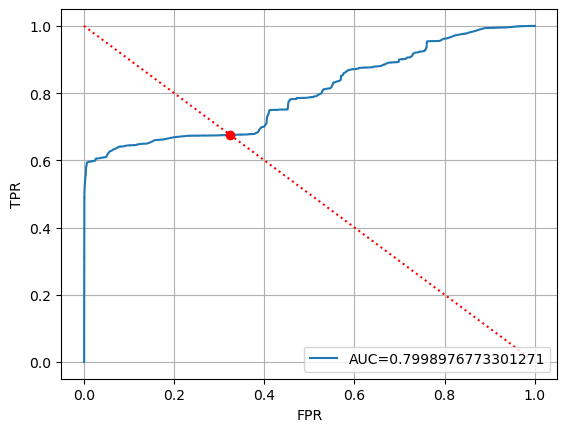

In [36]:
threshold = ROC(y_test,y_pred)

In [37]:
threshold

array([0.3293085], dtype=float32)

best: 0.1469387755102041 F1: 0.7205742893059568


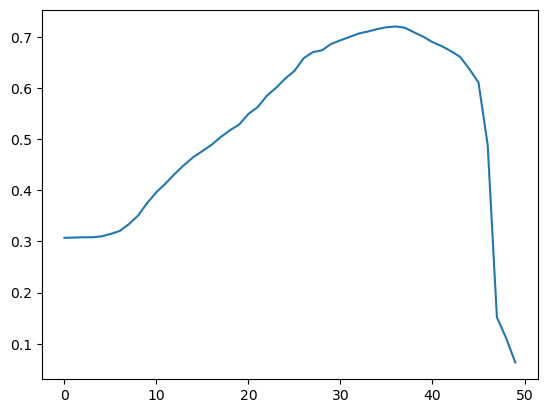

In [39]:
ff = 0
f_history = []
best = -1
for inc in np.linspace(0, 0.2, 50):
    y_pred_int = [1 if (yy > 0.3 + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

In [58]:
y_pred_int = [1 if (yy > 0.5775) else 0 for yy in y_pred]
conf_matrix = confusion_matrix(y_test, y_pred_int)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
F1 = f1_score(y_test, y_pred_int)

precision = precision_score(y_test, y_pred_int)
recall = recall_score(y_test, y_pred_int)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", F1)
print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')

Precision: 0.7332721863045569
Recall: 0.5958986292404465
F1 Score: 0.6574864352552979
TP: 32778
TN: 382978
FP: 11923
FN: 22228


In [90]:
best

0.012121212121212121